# Retrieve Lifelog Image With Graph

In [1]:
import os
import joblib
import json
from tqdm import tqdm
import numpy as np
import multiprocessing as mp
os.sys.path.append('./Embedding-SG')
import graph_lib
os.sys.path.append('./Parsing-Query')
import nlp_lib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

EMBED_SG_FOLDER = '/mnt/DATA/nmduy/MMM2021/graph_matrix/score_matrix_concatenate_lsc2018.joblib'
IMAGE_FOLDER = '/mnt/DATA/lsc2020'
VG_SGG_DICTS = '/home/nmduy/Scene-Graph-Benchmark.pytorch/datasets/vg/VG-SGG-dicts-with-attri.json' # ENCODED DICTIONARY FROM VISUAL GENOME DATASET (PROVIDED IN THE ORIGINAL REPO OF KAIHUATANG)

# TIME AND LOCATION INFORMATION
mysceal_location = joblib.load(f'/mnt/DATA/nmduy/MMM2021/graph_matrix/mysceal_location.joblib')
mysceal_time = joblib.load(f'/mnt/DATA/nmduy/MMM2021/graph_matrix/mysceal_time.joblib')

print('Loading joblib file ...')
embed_matrix = joblib.load(EMBED_SG_FOLDER)
print('Loading joblib file --> DONE!')

with open(VG_SGG_DICTS) as f:
    info_dict = json.load(f)
    
list_days = list(embed_matrix.keys())


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/sgg/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Loading word2vec model in graph_lib
Loading word2vec model in graph_lib --> DONE!
Loading joblib file ...
Loading joblib file --> DONE!


In [34]:
def show_result_images(id_img_ranking, numb_show=10):
    images = []
    for id_img in id_img_ranking[0:numb_show]:
        images.append(mpimg.imread(f"{IMAGE_FOLDER}/{id_img}"))

    plt.figure(figsize=(25,12))
    columns = 5
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)
        plt.axis('off')
        
def find_similar_singlecore(query_score, embed_matrix, alpha=1, beta=1):
    score = np.zeros(len(embed_matrix))
    list_days = list(embed_matrix.keys())
    
    for idx in range(len(score)):
        score_node, score_pred = graph_lib.similar_score(embed_matrix[list_days[idx]], query_score)
        score[idx] = alpha*score_node + beta*score_pred
        
    return score

def time_filter_result(initial_id_img_ranking, initial_score_ranking, query_info, mysceal_time_metadata):
    query_start_time = query_info['start_time'][0]
    query_end_time = query_info['end_time'][0]
    query_date = query_info['date']
    query_weekday = query_info['weekday']
    
    discard_index = []
    
    if query_start_time == 0 and query_end_time == 24 and len(query_weekday) == 0 and len(query_date) == 0: # DO NOT THING
        return initial_id_img_ranking, initial_score_ranking
    
    for idx, img_id in enumerate(initial_id_img_ranking):
        if query_start_time > 0:
            # process start time filter
            if mysceal_time_metadata[img_id]['hour'] < query_start_time:
                discard_index.append(idx)
                continue

        if query_end_time < 24:
            # process end_time filter
            if mysceal_time_metadata[img_id]['hour'] > query_end_time:
                discard_index.append(idx)
                continue

        if len(query_weekday) > 0:
            # process filter weekday
            if mysceal_time_metadata[img_id]['weekday'] not in query_weekday:
                discard_index.append(idx)
                continue

        if len(query_date) > 0:
            # process filter date
            date = query_date[0]
            year, month, day = date
            if year is not None: 
                if mysceal_time_metadata[img_id]['year'] != year :
                    discard_index.append(idx)
                    continue
            if month is not None: 
                if mysceal_time_metadata[img_id]['month'] != month :
                    discard_index.append(idx)
                    continue
            if day is not None: 
                if mysceal_time_metadata[img_id]['day'] != day :
                    discard_index.append(idx)
                    continue

    keep_index = [x for x in range(len(initial_id_img_ranking)) if x not in discard_index]

    id_img_time_filter = [initial_id_img_ranking[x] for x in keep_index]
    score_img_time_filter = initial_score_ranking[keep_index]
    
    return id_img_time_filter, score_img_time_filter

def location_filter_result(id_img_time_filter, score_time_filter, query_info, mysceal_location_metadata):
    ## LOCATION FILTER
    query_location = query_info['region']+query_info['location']
    inc_location = 0.1
    ini_bonus = 5
    inc_list = [1 for x in range(len(id_img_time_filter))]
    
#     if len(query_location) == 0:
#         return id_img_time_filter, score_time_filter
    
    for idx_img, img_id in enumerate(id_img_time_filter):
        increment = 0
        if len(query_location) > 0:
            # process location filter
            count = 0
            total = 0
            for idx, que_loc in enumerate(query_location):
                word = que_loc.split(' ')
                word = [x for x in word if x not in ['a', 'the']]
                for w in word:
                    total += 1
                    if w in mysceal_location_metadata[img_id]:
                        count += 1

            increment = increment + count / total * inc_location
        
#         if increment > 0:
#             print(idx_img)
        inc_list[idx_img] = (1+increment)

    inc_value = np.asarray(inc_list)
    score_location_filter = (score_time_filter+ini_bonus) * inc_value
    idx_ranking = np.argsort(score_location_filter)[::-1].tolist()
    score_location_filter = score_location_filter[idx_ranking]
    id_img_location_filter = [id_img_time_filter[x] for x in idx_ranking]
    
    return id_img_location_filter, score_location_filter

import multiprocessing as mp
# try:
#     mp.set_start_method('spawn')
# except RuntimeError:
#     raise

def time_filter_each_image(idx, mysceal_time_img, query_info):
    score = 0 # 0 is ok , 1 is filtered out
    
    query_start_time = query_info['start_time'][0]
    query_end_time = query_info['end_time'][0]
    query_date = query_info['date']
    query_weekday = query_info['weekday']
    
    if query_start_time > 0:
        # process start time filter
        if mysceal_time_img['hour'] < query_start_time:
            score = 1
            return (idx, score)

    if query_end_time < 24:
        # process end_time filter
        if mysceal_time_img['hour'] > query_end_time:
            score = 1
            return (idx, score)

    if len(query_weekday) > 0:
        # process filter weekday
        if mysceal_time_img['weekday'] not in query_weekday:
            score = 1
            return (idx, score)

    if len(query_date) > 0:
        # process filter date
        date = query_date[0]
        year, month, day = date
        if year is not None: 
            if mysceal_time_img['year'] != year :
                score = 1
                return (idx, score)
        if month is not None: 
            if mysceal_time_img['month'] != month :
                score = 1
                return (idx, score)
        if day is not None: 
            if mysceal_time_img['day'] != day :
                score = 1
                return (idx, score)
            
    return (idx, score)

def time_filter_result_multicore(initial_id_img_ranking, initial_score_ranking, query_info, mysceal_time_metadata, numb_core=None):
    query_start_time = query_info['start_time'][0]
    query_end_time = query_info['end_time'][0]
    query_date = query_info['date']
    query_weekday = query_info['weekday']
    
    if query_start_time == 0 and query_end_time == 24 and len(query_weekday) == 0 and len(query_date) == 0: # DO NOTHING
        return initial_id_img_ranking, initial_score_ranking
    
    # MULTIPROCESSING 
    if numb_core is None:
        pool = mp.Pool(mp.cpu_count())
    else:
        pool = mp.Pool(numb_core)
    # call apply_async() without callback
    result_objects = [pool.apply_async(time_filter_each_image, args=(i, mysceal_time_metadata[img_id], query_info)) for i, img_id in enumerate(initial_id_img_ranking)]
    # result_objects is a list of pool.ApplyResult objects
    filtered_out = [r.get()[1] for r in result_objects]
    pool.close()
    pool.join()
    
    keep_index = [idx for idx, x in enumerate(filtered_out) if x == 0]
    
    id_img_time_filter = [initial_id_img_ranking[x] for x in keep_index]
    score_img_time_filter = initial_score_ranking[keep_index]
    
    return id_img_time_filter, score_img_time_filter

In [4]:
query_text = 'it was at the helix'
processed_query, query_info = nlp_lib.pre_process_query(query_text)

query_location = query_info['region']+query_info['location']
query_start_time = query_info['start_time'][0]
query_end_time = query_info['end_time'][0]
query_date = query_info['date']
query_weekday = query_info['weekday']

[('it', 'PRP'), ('was', 'WAS'), ('at', 'IN'), ('the helix', 'LOCATION')]


In [7]:
query_info

{'region': [],
 'location': ['the helix'],
 'weekday': [],
 'start_time': (0, 0),
 'end_time': (24, 0),
 'date': []}

In [8]:
processed_query

'it was'

In [9]:
G_text, text_sgg = nlp_lib.generate_Graph_from_Text(text=processed_query)
node_matrix, pred_matrix = graph_lib.get_graph_embedding_concatenate(G_text)
query_score = {}
query_score['nodes'] = node_matrix
query_score['edges'] = pred_matrix
#graph_lib.draw_Graph(G_text, show_predicate=True)

In [10]:
initial_score = find_similar_singlecore(query_score, embed_matrix, alpha=1, beta=1.7)
idx_ranking = np.argsort(initial_score)[::-1].tolist()
initial_score = initial_score[idx_ranking]
id_img_ranking = [list_days[x] for x in idx_ranking]
len(id_img_ranking)

41666

In [33]:
id_img_ranking

['2016-09-10/20160910_215317_000.jpg',
 '2016-08-25/20160825_080114_000.jpg',
 '2016-08-25/20160825_081051_000.jpg',
 '2016-08-25/20160825_081019_000.jpg',
 '2016-08-25/20160825_080947_000.jpg',
 '2016-08-25/20160825_080915_000.jpg',
 '2016-08-25/20160825_080843_000.jpg',
 '2016-08-25/20160825_080811_000.jpg',
 '2016-08-25/20160825_080739_000.jpg',
 '2016-08-25/20160825_080707_000.jpg',
 '2016-08-25/20160825_080635_000.jpg',
 '2016-08-25/20160825_080603_000.jpg',
 '2016-08-25/20160825_080531_000.jpg',
 '2016-08-25/20160825_080459_000.jpg',
 '2016-08-25/20160825_080427_000.jpg',
 '2016-08-25/20160825_080355_000.jpg',
 '2016-08-25/20160825_080323_000.jpg',
 '2016-08-25/20160825_080251_000.jpg',
 '2016-08-25/20160825_080219_000.jpg',
 '2016-08-25/20160825_081123_000.jpg',
 '2016-08-25/20160825_081155_000.jpg',
 '2016-08-25/20160825_081227_000.jpg',
 '2016-08-25/20160825_081800_000.jpg',
 '2016-08-25/20160825_082144_000.jpg',
 '2016-08-25/20160825_082112_000.jpg',
 '2016-08-25/20160825_082

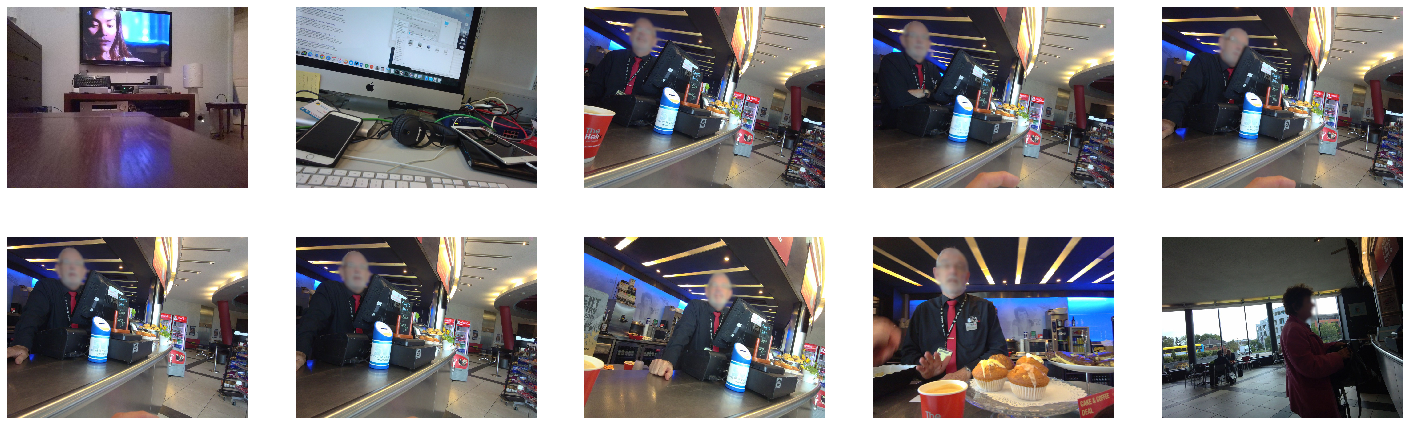

In [15]:
show_result_images(id_img_ranking,10)

In [13]:
# import time
# start_time = time.time()
# id_img_time_filter, score_time_filter = time_filter_result(id_img_ranking, initial_score, query_info, mysceal_time)
# end_single = time.time()
# id_img_time_filter_m, score_time_filter_m = time_filter_result_multicore(id_img_ranking, initial_score, query_info, mysceal_time)
# end_multi = time.time()

# duration_single = round(end_single - start_time, 2)
# duration_multi = round(end_multi - end_single, 2)

# print(f"Single: {duration_single}s - Multi: {duration_multi}s")
id_img_time_filter, score_time_filter = time_filter_result_multicore(id_img_ranking, initial_score, query_info, mysceal_time)

In [35]:
id_img_location_filter, score_location_filter = location_filter_result(id_img_time_filter, score_time_filter, query_info, mysceal_location)

In [38]:
mysceal_location['2016-08-25/20160825_080915_000.jpg']

['helix', 'dcu', 'northside', 'ireland', 'dublin', 'county', 'europe']

In [39]:
mysceal_location['2016-08-26/20160826_072914_000.jpg']

['helix', 'ireland', 'artane', '-', 'whitehall', 'dublin', 'county', 'europe']

In [36]:
id_img_location_filter

['2016-08-26/20160826_072914_000.jpg',
 '2016-09-01/20160901_074834_000.jpg',
 '2016-08-31/20160831_114919_000.jpg',
 '2016-08-31/20160831_114951_000.jpg',
 '2016-08-31/20160831_115023_000.jpg',
 '2016-08-31/20160831_115055_000.jpg',
 '2016-08-31/20160831_115127_000.jpg',
 '2016-08-31/20160831_115159_000.jpg',
 '2016-08-31/20160831_115751_000.jpg',
 '2016-08-31/20160831_115231_000.jpg',
 '2016-08-31/20160831_115335_000.jpg',
 '2016-08-31/20160831_115407_000.jpg',
 '2016-08-31/20160831_115439_000.jpg',
 '2016-08-31/20160831_115511_000.jpg',
 '2016-08-31/20160831_115543_000.jpg',
 '2016-08-31/20160831_115615_000.jpg',
 '2016-08-31/20160831_115647_000.jpg',
 '2016-08-31/20160831_115303_000.jpg',
 '2016-08-31/20160831_120844_000.jpg',
 '2016-08-31/20160831_120917_000.jpg',
 '2016-08-31/20160831_120949_000.jpg',
 '2016-08-31/20160831_122146_000.jpg',
 '2016-08-31/20160831_122218_000.jpg',
 '2016-08-31/20160831_122250_000.jpg',
 '2016-08-31/20160831_122322_000.jpg',
 '2016-08-31/20160831_122

In [31]:
initial_score[2]

0.0

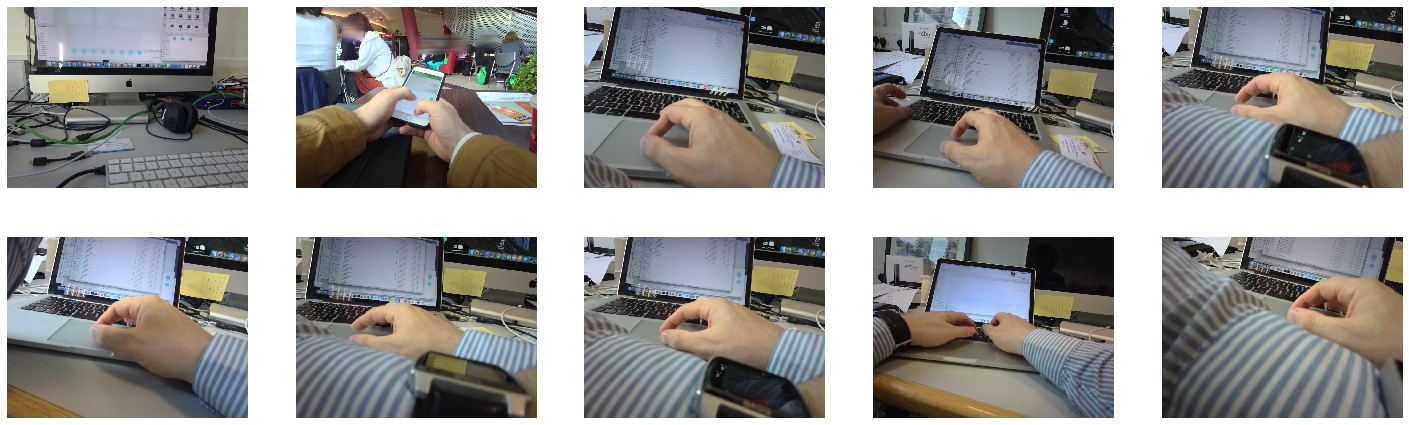

In [37]:
show_result_images(id_img_location_filter,10)

In [72]:
score_location_filter[0:10]

array([41.11230172, 41.11230172, 41.11230172, 41.11230172, 41.11230172,
       41.11230172, 41.11230172, 41.11230172, 41.11230172, 41.11230172])

In [73]:
score_time_filter[0:10]

array([41.11230172, 41.11230172, 41.11230172, 41.11230172, 41.11230172,
       41.11230172, 41.11230172, 41.11230172, 41.11230172, 41.11230172])